In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

INPUT_CSV = "output/processed_dataset.csv"
INPUT_2024_CSV = "output/processed_2024_dataset.csv"

print("Loading datasets...")
df = pd.read_csv(INPUT_CSV)
df_2024 = pd.read_csv(INPUT_2024_CSV)

train_df = df[df["year"].between(2005, 2022)]
test_df = df[df["year"] == 2023]

feature_cols = [c for c in train_df.columns if c not in ["ticker", "year", "beat_index"]]
if not feature_cols:
    raise ValueError("No feature columns found. Check processed_dataset.csv.")
X_train = train_df[feature_cols]
X_test = test_df[feature_cols]
y_train = 1 - train_df["beat_index"]
y_test = 1 - test_df["beat_index"]
X_2024 = df_2024[feature_cols]

if y_train.isna().any() or y_test.isna().any():
    raise ValueError("Missing labels in train or test data. Check beat_index column.")

num_negative = sum(y_train == 0) 
num_positive = sum(y_train == 1) 
scale_pos_weight = num_negative / num_positive if num_positive > 0 else 1
print(f"Class imbalance ratio (negative/positive): {scale_pos_weight:.3f}")

print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_2024_scaled = scaler.transform(X_2024)

Loading datasets...
Class imbalance ratio (negative/positive): 1.161
Scaling features...


Training XGBoost model...
Optimizing threshold for training F1...
Best training F1: 0.817 at threshold 0.481


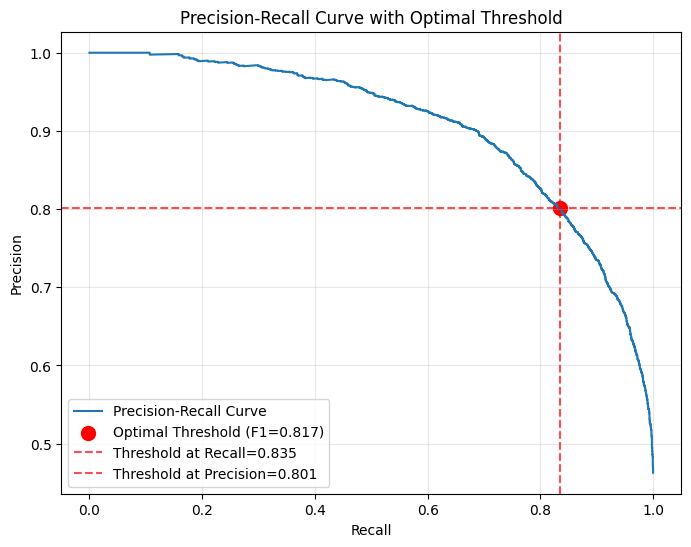

At optimal threshold 0.481:
Precision: 0.801
Recall: 0.835


In [2]:
print("Training XGBoost model...")
model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
model.fit(X_train_scaled, y_train)

print("Optimizing threshold for training F1...")
proba_train = model.predict_proba(X_train_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, proba_train)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] if thresholds[best_idx] <= 1.0 else 0.5
best_f1 = f1_scores[best_idx]
print(f"Best training F1: {best_f1:.3f} at threshold {best_threshold:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red', s=100, label=f'Optimal Threshold (F1={best_f1:.3f})')
plt.axvline(x=recall[best_idx], color='red', linestyle='--', alpha=0.7, label=f'Threshold at Recall={recall[best_idx]:.3f}')
plt.axhline(y=precision[best_idx], color='red', linestyle='--', alpha=0.7, label=f'Threshold at Precision={precision[best_idx]:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Optimal Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"At optimal threshold {best_threshold:.3f}:")
print(f"Precision: {precision[best_idx]:.3f}")
print(f"Recall: {recall[best_idx]:.3f}")